In [10]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pathlib import Path
import astropy.units as u
import pkg_resources
from astropy.coordinates import Distance
from astropy.constants import k_B, m_e, c, G, M_sun, e , h
from agnpy.utils.plot import sed_x_label, sed_y_label
# gammapy modules
from gammapy.modeling.models import (
    SpectralModel,
    Parameter,
    SPECTRAL_MODEL_REGISTRY,
    SkyModel,
)
from gammapy.estimators import FluxPoints
from gammapy.datasets import FluxPointsDataset
from gammapy.modeling import Fit
from agnpy.spectra import BrokenPowerLaw
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton, ExternalCompton
from agnpy.targets import SSDisk, RingDustTorus
from sherpa import data
from sherpa.models import model
from ruamel.yaml import YAML
from astropy.table import Table
from astropy.coordinates import Distance
from gammapy.estimators import FluxPoints
from astropy.constants import codata2014 as constant

from gammapy.modeling import Fit
from gammapy.modeling.sampling import (
    run_mcmc,
    par_to_model,
    plot_corner,
    plot_trace,
)

In [11]:
# constants
mec2 = m_e.to("erg", equivalencies=u.mass_energy())
gamma_size = 400
gamma_to_integrate = np.logspace(0, 7, gamma_size)

In [12]:
class AgnpyEC(SpectralModel):
    """Wrapper of agnpy's non synchrotron, SSC and EC classes. The flux model
    accounts for the Disk and DT's thermal SEDs. 
    A broken power law is assumed for the electron spectrum.
    To limit the span of the parameters space, we fit the log10 of the parameters 
    whose range is expected to cover several orders of magnitudes (normalisation, 
    gammas, size and magnetic field of the blob). 
    """

    tag = "EC"
    log10_k_e = Parameter("log10_k_e", -5, min=-20, max=2)
    p1 = Parameter("p1", 2.1, min=1.0, max=5.0)
    p2 = Parameter("p2", 3.1, min=1.0, max=5.0)
    log10_gamma_b = Parameter("log10_gamma_b", 3, min=1, max=6)
    log10_gamma_min = Parameter("log10_gamma_min", 1, min=0, max=4)
    log10_gamma_max = Parameter("log10_gamma_max", 5, min=3, max=8)
    # source general parameters
    z = Parameter("z", 0.1, min=0.01, max=1)
    d_L = Parameter("d_L", "1e27 cm", min=1e25, max=1e33)
    # emission region parameters
    delta_D = Parameter("delta_D", 10, min=1, max=40)
    log10_B = Parameter("log10_B", 0.0, min=-3.0, max=1.0)
    t_var = Parameter("t_var", "600 s", min=10, max=np.pi * 1e7)
    mu_s = Parameter("mu_s", 0.9, min=0.0, max=1.0)
    log10_r = Parameter("log10_r", 17.0, min=16.0, max=20.0)
    # disk parameters
    log10_L_disk = Parameter("log10_L_disk", 45.0, min=42.0, max=48.0)
    log10_M_BH = Parameter("log10_M_BH", 42, min=32, max=45)
    m_dot = Parameter("m_dot", "1e26 g s-1", min=1e24, max=1e30)
    R_in = Parameter("R_in", "1e14 cm", min=1e12, max=1e16)
    R_out = Parameter("R_out", "1e17 cm", min=1e12, max=1e19)
    # DT parameters
    xi_dt = Parameter("xi_dt", 0.6, min=0.0, max=1.0)
    T_dt = Parameter("T_dt", "1e3 K", min=1e2, max=1e4)
    R_dt = Parameter("R_dt", "2.5e18 cm", min=1.0e17, max=1.0e19)

    @staticmethod
    def evaluate(
        energy,
        log10_k_e,
        p1,
        p2,
        log10_gamma_b,
        log10_gamma_min,
        log10_gamma_max,
        z,
        d_L,
        delta_D,
        log10_B,
        t_var,
        mu_s,
        log10_r,
        log10_L_disk,
        log10_M_BH,
        m_dot,
        R_in,
        R_out,
        xi_dt,
        T_dt,
        R_dt,
    ):
        # conversion
        k_e = 10 ** log10_k_e * u.Unit("cm-3")
        gamma_b = 10 ** log10_gamma_b
        gamma_min = 10 ** log10_gamma_min
        gamma_max = 10 ** log10_gamma_max
        B = 10 ** log10_B * u.G
        R_b = (c * t_var * delta_D / (1 + z)).to("cm")
        r = 10 ** log10_r * u.cm
        L_disk = 10 ** log10_L_disk * u.Unit("erg s-1")
        M_BH = 10 ** log10_M_BH * u.Unit("g")
        eps_dt = 2.7 * (k_B * T_dt / mec2).to_value("")

        nu = energy.to("Hz", equivalencies=u.spectral())

        # non-thermal components
        sed_synch = Synchrotron.evaluate_sed_flux(
            nu,
            z,
            d_L,
            delta_D,
            B,
            R_b,
            BrokenPowerLaw,
            k_e,
            p1,
            p2,
            gamma_b,
            gamma_min,
            gamma_max,
            ssa=True,
            gamma=gamma_to_integrate,
        )
        sed_ssc = SynchrotronSelfCompton.evaluate_sed_flux(
            nu,
            z,
            d_L,
            delta_D,
            B,
            R_b,
            BrokenPowerLaw,
            k_e,
            p1,
            p2,
            gamma_b,
            gamma_min,
            gamma_max,
            ssa=True,
            gamma=gamma_to_integrate,
        )
        sed_ec_dt = ExternalCompton.evaluate_sed_flux_dt(
            nu,
            z,
            d_L,
            delta_D,
            mu_s,
            R_b,
            L_disk,
            xi_dt,
            eps_dt,
            R_dt,
            r,
            BrokenPowerLaw,
            k_e,
            p1,
            p2,
            gamma_b,
            gamma_min,
            gamma_max,
            gamma=gamma_to_integrate,
        )

        # thermal components
        sed_bb_disk = SSDisk.evaluate_multi_T_bb_norm_sed(
            nu, z, L_disk, M_BH, m_dot, R_in, R_out, d_L
        )
        sed_bb_dt = RingDustTorus.evaluate_bb_norm_sed(
            nu, z, xi_dt * L_disk, T_dt, R_dt, d_L
        )

        sed = sed_synch + sed_ssc + sed_ec_dt + sed_bb_disk + sed_bb_dt

        return (sed / energy ** 2).to("1 / (cm2 eV s)")


SPECTRAL_MODEL_REGISTRY.append(AgnpyEC)

/home/pc/miniconda3/lib/python3.8/site-packages/gammapy/estimators/flux_point.py:667: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/home/pc/miniconda3/lib/python3.8/site-packages/gammapy/estimators/flux_point.py:668: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy="clip")


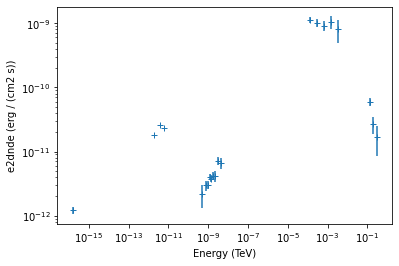

        e_ref             e2dnde     e2dnde_errn   e2dnde_errp 
          eV          erg / (cm2 s) erg / (cm2 s) erg / (cm2 s)
--------------------- ------------- ------------- -------------
0.0001530197047861828      1.21e-12     1.517e-13     1.517e-13
    1.935492482160366      1.79e-11     2.802e-13     2.802e-13
    3.577766124608831     2.564e-11     5.837e-13     5.837e-13
    6.025667834418062     2.291e-11      5.73e-13      5.73e-13
    485.1138208491687     2.154e-12     8.459e-13     8.459e-13
     789.912530112457      2.97e-12     5.263e-13     5.263e-13
   1019.8556540614236     3.064e-12     4.325e-13     4.325e-13
   1220.0219705925383      4.06e-12      4.77e-13      4.77e-13
    1435.076690832579     3.776e-12     4.738e-13     4.738e-13
    1744.838201332176     4.171e-12     5.803e-13     5.803e-13
    2320.109577974285     4.126e-12     7.895e-13     7.895e-13
   3095.1337043778162     7.234e-12     1.116e-12     1.116e-12
    4230.788053953108     6.601e-12     

In [13]:
sed_path = '/home/pc/Desktop/PKS1510_modelling-main/data/data_mcmc/PKS1510-089_2015a.ecsv'
flux_points = FluxPoints.read(sed_path)
flux_points.plot()
plt.show()
#print(flux_points.table)

In [15]:
# array of systematic errors, will just be summed in quadrature to the statistical error
# we assume
# - 30% on VHE gamma-ray instruments
# - 10% on HE gamma-ray instruments
# - 10% on X-ray instruments
# - 5% on lower-energy instruments

x = flux_points.table["e_ref"]
y = flux_points.table["e2dnde"]
y_err_stat = flux_points.table["e2dnde_errn"]
y_err_syst = np.zeros(len(x))

# define energy ranges
e_vhe = 100 * u.GeV
e_he = 0.1 * u.GeV
e_x_ray_max = 300 * u.keV
e_x_ray_min = 0.3 * u.keV
vhe_gamma = x >= e_vhe
he_gamma = (x >= e_he) * (x < e_vhe)
x_ray = (x >= e_x_ray_min) * (x < e_x_ray_max)
uv_to_radio = x < e_x_ray_min

# declare systematics
y_err_syst[vhe_gamma] = 0.30
y_err_syst[he_gamma] = 0.10
y_err_syst[x_ray] = 0.10
y_err_syst[uv_to_radio] = 0.05
y_err_syst = y * y_err_syst

# sum in quadrature the errors
flux_points.table["e2dnde_err"] = np.sqrt(y_err_stat ** 2 + y_err_syst ** 2)
flux_points = flux_points.to_sed_type("dnde")

In [16]:
# declare a model
agnpy_ec = AgnpyEC()

# initialise parameters
z = 0.361
d_L = Distance(z=z).to("cm")
# - blob
Gamma = 20
delta_D = 25
Beta = np.sqrt(1 - 1 / np.power(Gamma, 2))  # jet relativistic speed
mu_s = (1 - 1 / (Gamma * delta_D)) / Beta  # viewing angle
B = 0.35 * u.G
# - disk
L_disk = 6.7e45 * u.Unit("erg s-1")  # disk luminosity
M_BH = 5.71 * 1e7 * M_sun
eta = 1 / 12
m_dot = (L_disk / (eta * c ** 2)).to("g s-1")
R_g = ((G * M_BH) / c ** 2).to("cm")
R_in = 6 * R_g
R_out = 10000 * R_g
# - DT
xi_dt = 0.6  # fraction of disk luminosity reprocessed by the DT
T_dt = 1e3 * u.K
R_dt = 6.47 * 1e18 * u.cm
# - size and location of the emission region
t_var = 0.5 * u.d
r = 6e17 * u.cm

# instance of the model wrapping angpy functionalities
# - AGN parameters
# -- distances
agnpy_ec.z.quantity = z
agnpy_ec.z.frozen = True
agnpy_ec.d_L.quantity = d_L.cgs.value
agnpy_ec.d_L.frozen = True
# -- SS disk
agnpy_ec.log10_L_disk.quantity = np.log10(L_disk.to_value("erg s-1"))
agnpy_ec.log10_L_disk.frozen = True
agnpy_ec.log10_M_BH.quantity = np.log10(M_BH.to_value("g"))
agnpy_ec.log10_M_BH.frozen = True
agnpy_ec.m_dot.quantity = m_dot
agnpy_ec.m_dot.frozen = True
agnpy_ec.R_in.quantity = R_in
agnpy_ec.R_in.frozen = True
agnpy_ec.R_out.quantity = R_out
agnpy_ec.R_out.frozen = True
# -- Dust Torus
agnpy_ec.xi_dt.quantity = xi_dt
agnpy_ec.xi_dt.frozen = True
agnpy_ec.T_dt.quantity = T_dt
agnpy_ec.T_dt.frozen = True
agnpy_ec.R_dt.quantity = R_dt
agnpy_ec.R_dt.frozen = True
# - blob parameters
agnpy_ec.delta_D.quantity = delta_D
agnpy_ec.delta_D.frozen = True
agnpy_ec.log10_B.quantity = np.log10(B.to_value("G"))
agnpy_ec.mu_s.quantity = mu_s
agnpy_ec.mu_s.frozen = True
agnpy_ec.t_var.quantity = t_var
agnpy_ec.t_var.frozen = True
agnpy_ec.log10_r.quantity = np.log10(r.to_value("cm"))
agnpy_ec.log10_r.frozen = True
# - EED
agnpy_ec.log10_k_e.quantity = np.log10(0.06)
agnpy_ec.p1.quantity = 1.8
agnpy_ec.p2.quantity = 3.5
agnpy_ec.log10_gamma_b.quantity = np.log10(500)
agnpy_ec.log10_gamma_min.quantity = np.log10(1)
agnpy_ec.log10_gamma_min.frozen = True
agnpy_ec.log10_gamma_max.quantity = np.log10(3e4)
agnpy_ec.log10_gamma_max.frozen = True

print(agnpy_ec)

AgnpyEC

      name         value     unit    min        max    frozen   error  
--------------- ----------- ----- ---------- --------- ------ ---------
      log10_k_e -1.2218e+00       -2.000e+01 2.000e+00  False 0.000e+00
             p1  1.8000e+00        1.000e+00 5.000e+00  False 0.000e+00
             p2  3.5000e+00        1.000e+00 5.000e+00  False 0.000e+00
  log10_gamma_b  2.6990e+00        1.000e+00 6.000e+00  False 0.000e+00
log10_gamma_min  0.0000e+00        0.000e+00 4.000e+00   True 0.000e+00
log10_gamma_max  4.4771e+00        3.000e+00 8.000e+00   True 0.000e+00
              z  3.6100e-01        1.000e-02 1.000e+00   True 0.000e+00
            d_L  6.1289e+27    cm  1.000e+25 1.000e+33   True 0.000e+00
        delta_D  2.5000e+01        1.000e+00 4.000e+01   True 0.000e+00
        log10_B -4.5593e-01       -3.000e+00 1.000e+00  False 0.000e+00
          t_var  4.3200e+04     s  1.000e+01 3.142e+07   True 0.000e+00
           mu_s  9.9925e-01        0.000e+00 1.000e+00 

AttributeError: type object 'SSDisk' has no attribute 'evaluate_multi_T_bb_norm_sed'

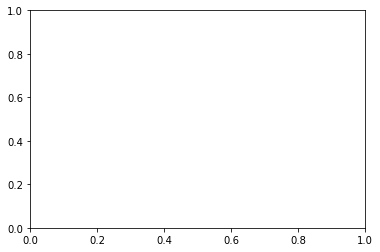

In [18]:
# plot initial model
agnpy_ec.plot(energy_range=[1e-6, 1e15] * u.eV, energy_unit="eV", energy_power=2)
flux_points.plot(energy_unit="eV", energy_power=2)
plt.ylim([1e-14, 1e-8])
plt.show()

In [9]:
# define model
model = SkyModel(name="PKS1510-089_EC", spectral_model=agnpy_ec)
dataset_ec = FluxPointsDataset(model, flux_points)
# do not use frequency point below 1e11 Hz, affected by non-blazar emission
E_min_fit = (1e11 * u.Hz).to("eV", equivalencies=u.spectral())
dataset_ec.mask_fit = dataset_ec.data.energy_ref > E_min_fit

/home/pc/miniconda3/lib/python3.8/site-packages/agnpy/synchrotron/synchrotron.py:67: RuntimeWarning: divide by zero encountered in true_divide
  u = 1 / 2 + np.exp(-tau) / tau - (1 - np.exp(-tau)) / np.power(tau, 2)
/home/pc/miniconda3/lib/python3.8/site-packages/agnpy/synchrotron/synchrotron.py:67: RuntimeWarning: invalid value encountered in true_divide
  u = 1 / 2 + np.exp(-tau) / tau - (1 - np.exp(-tau)) / np.power(tau, 2)


AttributeError: type object 'SSDisk' has no attribute 'evaluate_multi_T_bb_norm_sed'

In [27]:
%%time
sampler = run_mcmc(dataset_ec, nwalkers=16, nrun=500)  # to speedup the notebook

ValueError: Probability function returned NaN